In [1]:
# basic
import numpy as np
import pandas as pd



In [2]:
# get data
import pandas_datareader as pdr

# visual
import matplotlib.pyplot as plt
%matplotlib inline

#time
import datetime as datetime

#Prophet
from fbprophet import Prophet


from sklearn import metrics

In [42]:
start = datetime.datetime(2018,6,1)
df_2492 = pdr.DataReader('2330.TW', 'yahoo', start=start)
df_2492.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-06-01,226.5,224.0,224.5,224.0,27617994.0,216.123077
2018-06-04,229.0,227.0,227.5,229.0,25959480.0,220.947250
2018-06-05,230.0,226.5,230.0,229.0,26534884.0,220.947250
2018-06-06,230.0,227.0,229.0,230.0,24767441.0,221.912094
2018-06-07,231.5,228.0,231.0,230.0,24958266.0,221.912094


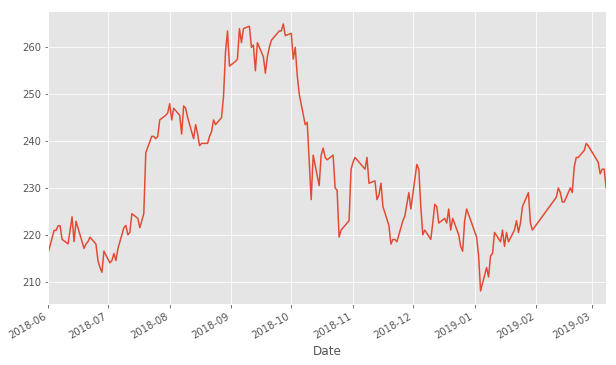

In [43]:
plt.style.use('ggplot')
df_2492['Adj Close'].plot(figsize=(10, 6));

In [44]:
new_df_2492 = pd.DataFrame(df_2492['Adj Close']).reset_index().rename(columns={'Date':'ds', 'Adj Close':'y'})
new_df_2492.head()

,ds,y
0,2018-06-01,216.123077
1,2018-06-04,220.947250
2,2018-06-05,220.947250
3,2018-06-06,221.912094
4,2018-06-07,221.912094


In [45]:
new_df_2492['y'] = np.log(new_df_2492['y'])
# 定義模型
model = Prophet()

# 訓練模型
model.fit(new_df_2492)

# 建構預測集
future = model.make_future_dataframe(periods=365) #forecasting for 1 year from now.

# 進行預測
forecast = model.predict(future)

forecast.head()

/Users/deanchu/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/deanchu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-01,5.393655,5.379529,5.421611,5.393655,5.393655,0.006628,0.006628,0.006628,0.006628,0.006628,0.006628,0.0,0.0,0.0,5.400284
1,2018-06-04,5.390946,5.375322,5.418839,5.390946,5.390946,0.006385,0.006385,0.006385,0.006385,0.006385,0.006385,0.0,0.0,0.0,5.397331
2,2018-06-05,5.390043,5.372878,5.414915,5.390043,5.390043,0.003935,0.003935,0.003935,0.003935,0.003935,0.003935,0.0,0.0,0.0,5.393978
3,2018-06-06,5.389140,5.377019,5.420214,5.389140,5.389140,0.009687,0.009687,0.009687,0.009687,0.009687,0.009687,0.0,0.0,0.0,5.398828
4,2018-06-07,5.388237,5.372412,5.414754,5.388237,5.388237,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128,0.0,0.0,0.0,5.393365


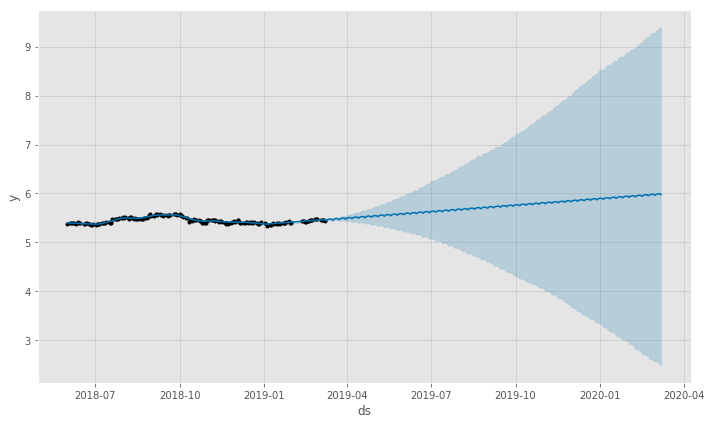

In [46]:
figure=model.plot(forecast)

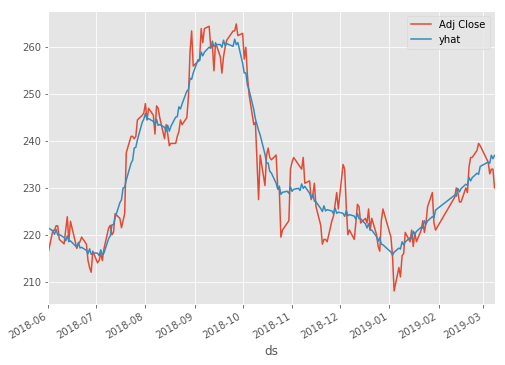

In [47]:
df_2492_close = pd.DataFrame(df_2492['Adj Close'])
two_years = forecast.set_index('ds').join(df_2492_close)
two_years = two_years[['Adj Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(800)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)
two_years[['Adj Close', 'yhat']].plot(figsize=(8, 6));

In [48]:
two_years_AE = (two_years.yhat - two_years['Adj Close'])
two_years_AE.describe()

count    187.000000
mean      -0.049026
std        3.947340
min      -10.441534
25%       -2.529292
50%       -0.205567
75%        2.314509
max       14.772398
dtype: float64

In [49]:
print ("MSE:",metrics.mean_squared_error(two_years.yhat, two_years['Adj Close']))

MSE: 15.500576880269277


In [50]:
print ("MAE:",metrics.mean_absolute_error(two_years.yhat, two_years['Adj Close']))

MAE: 3.088748122691543


Text(0.5, 0, 'Date')

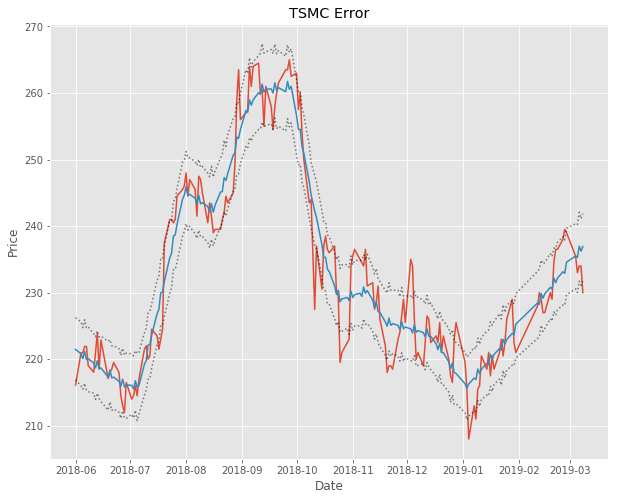

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(two_years['Adj Close'])
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title('TSMC Error')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In [52]:
import matplotlib
matplotlib.matplotlib_fname()

'/Users/deanchu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'